# word2vec
## 추론 기반 기법과 신경망

### 통계 기반 기법의 문제점
### 추론 기반 기법 개요
### 신경망에서의 단어 처리
* 원핫one-hot 표현

In [1]:
# 완전연결계층에 의한 변환
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) #입력
W = np.random.randn(7,3) # 가중치
h = np.matmul(c, W) # 중간 노드
print(h)

[[-1.16053762 -0.39602225  0.04428137]]


In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.99702154 1.79211499 1.51552051]]


## 단순한 word2vec
CBOW(Continuous-Bag of words)
### CBOW 모델의 추론 처리

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

#샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-1.75645584 -0.5832597  -0.23727578  0.60041533 -0.60367711 -1.67994275
  -0.83912101]]


### CBOW 모델의 학습
### word2vec의 가중치와 분산 표현

## 학습 데이터 준비
### 맥락과 타깃

In [5]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say yes and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'yes', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# 맥락과 타깃을 함수로 구현
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+ t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)
        

In [7]:
#실제로 사용
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [8]:
print(target)

[1 2 3 4 1 5]


In [9]:
#원핫 표현으로 변환
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say yes and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## CBOW 모델 구현
![img](./images/fig_3-19.png)

In [14]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현 저장
        self.word_vecs = W_in

In [11]:
# 신경망의 순전파 메서드 구현
def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

In [12]:
# 신경망의 역전파 구현
def backward(self, dout = 1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(Ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [18]:
# 학습 코드 구현
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
#trainer.plot()

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 299 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 300 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 301 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 302 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 303 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 304 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 305 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 306 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 307 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 308 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 309 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 310 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 311 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 312 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 313 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 314 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 315 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 316 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 317 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 318 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 319 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 320 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 321 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 322 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 323 |  반복 1

| 에폭 641 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 642 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 643 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 644 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 645 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 646 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 647 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 648 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 649 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 650 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 651 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 652 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 653 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 654 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 655 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 656 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 657 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 658 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 659 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 660 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 661 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 662 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 663 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 664 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 665 |  반복 1

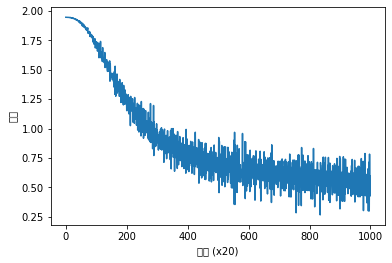

In [17]:
trainer.plot()

In [19]:
# 가중치 매개변수
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.0944971 -0.9836003  0.9824528  1.0401528 -1.4305817]
say [ 0.3051958   1.1755683  -1.1669714  -1.1928096  -0.08153486]
goodbye [-0.93275297 -0.8750018   0.88884366  0.7536418  -0.4130019 ]
and [ 1.529049    0.9550421  -0.94598705 -0.92362696 -1.6866    ]
i [-0.9512265  -0.87987596  0.8648011   0.76116747 -0.4067549 ]
hello [-1.0869912 -1.0032817  0.9837808  1.0148698 -1.4532112]
. [-1.5691944  1.1087282 -1.070612  -1.1174614  1.3775152]


## word2vec 보충
### CBOW 모델과 확률
### skip-gram 모델
### 통계 기반 vs. 추론 기반

## 정리
* 추론 기반 기법은 추측하는 것이 목적이며, 부산물로 단어의 분산 표현을 얻는다.
* word2vec은 추론 기반 기법이며 단순한 2층 신경망이다.
* word2vec은 skip-gram 모델과 CBOW 모델을 제공한다.
* CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)을 추측한다.
* 반대로 skip-gram 모델은 하나의 단어(타깃)으로부터 다수의 단어(맥락)을 추측한다.
* word2vec은 가중치를 다시 학습할 수 있으므로 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다.